In [1]:
import matplotlib.pyplot as plt
from datasets import load_dataset, DownloadManager, Image, load_from_disk, concatenate_datasets
import torch
from torch.utils.data import DataLoader
from diffusers import StableDiffusionPipeline
import PIL.Image
PIL.Image.MAX_IMAGE_PIXELS = None

%matplotlib inline
%load_ext autoreload
%autoreload 2
# This allows you to edit the .py source files and those updates also translate to the notebook

## Load datasets

In [2]:
# method used for adding a column called label to a huggingface dataset
def add_label(dataset_row, label):
    dataset_row['label'] = label
    return dataset_row

def resize_images(dataset_row):
    # the diffusion model generates images of size 512 x 512
    dataset_row['image'] = [image.resize((512, 512)) for image in dataset_row['image']]
    return dataset_row


#### Clothing dataset

Size: 14904
outer, The North Face 1996 Eco Nuptse Jacket Black, a photography of the north face black down jacket
Image Size: (512, 512)


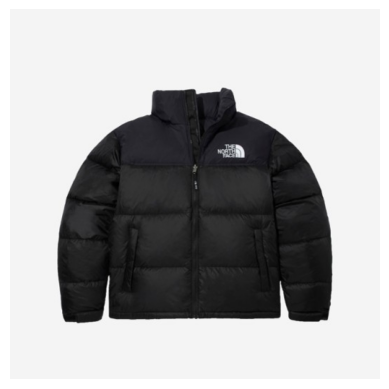

In [5]:
def get_clothes_dataset():
    dataset_path = './clothes_dataset'
    try:
        clothes_dataset = load_from_disk(dataset_path)
    except FileNotFoundError:
        clothes_dataset = load_dataset("hahminlew/kream-product-blip-captions", split="train") # only has a train split
        clothes_dataset = clothes_dataset.map(lambda row: add_label(row, 'clothes')).map(function=resize_images, batched=True, num_proc=6)
        clothes_dataset.save_to_disk(dataset_path)
    return clothes_dataset

clothes_dataset = get_clothes_dataset()
sample = clothes_dataset[0]
clothes_dataset_size = len(clothes_dataset)
print('Size:', clothes_dataset_size)
print(sample["text"])
print('Image Size:', sample['image'].size)
plt.axis('off')
plt.imshow(sample['image']) # originally, images are 525 x 525 pixels but are resized to 512 x 512

#### Cartoon pixel art dataset

Generating train split:   0%|          | 0/49859 [00:00<?, ? examples/s]

a pixel art character with square black glasses, a hotdog-shaped head and a peachy-colored body on a warm background
49859


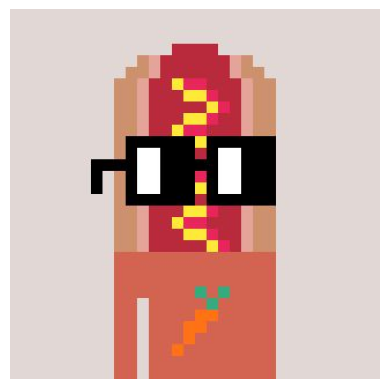

In [5]:
def get_pixelart_dataset(clothes_dataset_size):
    dataset_path = './pixelart_dataset'
    try:
        pixelart_dataset = load_from_disk(dataset_path)
    except FileNotFoundError:
        pixelart_dataset = load_dataset('m1guelpf/nouns', split='train') # only has a train split too
        pixelart_dataset = pixelart_dataset.select(range(clothes_dataset_size)).map(lambda row: add_label(row, 'pixel_art')).map(
            function=resize_images, batched=True, num_proc=6)
        pixelart_dataset.save_to_disk(dataset_path)
    return pixelart_dataset

pixelart_dataset = get_pixelart_dataset()
sample = pixelart_dataset[0]
print(sample["text"])
plt.axis('off')
plt.imshow(sample['image']) # originally, images are 320 x 320 pixels but are resized to 512 x 512

#### Realistic photograph dataset

In [9]:
def get_photograph_dataset(clothes_dataset_size):
    dataset_path = './photograph_dataset'

    try:
        photograph_dataset = load_from_disk(dataset_path)
    except FileNotFoundError:
        photograph_dataset = load_dataset('1aurent/unsplash-lite-palette', split='train') # also, this dataset only has train split
        photograph_dataset = photograph_dataset.select(range(clothes_dataset_size))

        def download_image(url: str | list[str], dl_manager: DownloadManager):
            filenames = dl_manager.download(url)
            return {"image": filenames}
        
        photograph_dataset = photograph_dataset.map(
            function=download_image,
            input_columns=["url"],
            fn_kwargs={
                "dl_manager": DownloadManager(),
            },
            batched=True,
            num_proc=1,
        )
        photograph_dataset = photograph_dataset.cast_column(
            column="image",
            feature=Image(),
        ).map(function=resize_images, batched=True, num_proc=1)
        photograph_dataset = photograph_dataset.remove_columns(['url', 'palettes'])
        photograph_dataset = photograph_dataset.rename_column('ai_description', 'text').map(lambda row: add_label(row, 'photographs'))
        photograph_dataset.save_to_disk(dataset_path)
    return photograph_dataset
    

Map:   0%|          | 0/14904 [00:00<?, ? examples/s]

/home/michaelga/DiffusionOfExperts/.venv/lib/python3.12/site-packages/PIL/Image.py:3218: DecompressionBombWarning: Image size (107424768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/michaelga/DiffusionOfExperts/.venv/lib/python3.12/site-packages/PIL/Image.py:3218: DecompressionBombWarning: Image size (96012000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/michaelga/DiffusionOfExperts/.venv/lib/python3.12/site-packages/PIL/Image.py:3218: DecompressionBombWarning: Image size (112211825 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/michaelga/DiffusionOfExperts/.venv/lib/python3.12/site-packages/PIL/Image.py:3218: DecompressionBombWarning: Image size (94212096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/michaelga/DiffusionOfExperts/.venv/lib/python3.12/si

Map:   0%|          | 0/14904 [00:00<?, ? examples/s]

Saving the dataset (0/11 shards):   0%|          | 0/14904 [00:00<?, ? examples/s]

silhouette of structure under red sky


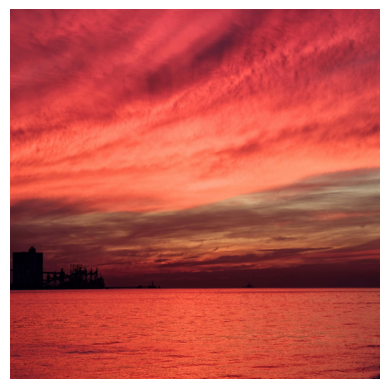

In [10]:
photo_graph_dataset = get_photograph_dataset(clothes_dataset_size)
sample = photo_graph_dataset[0]
print(sample["text"])
plt.axis('off')
plt.imshow(sample['image'])

In [2]:
def collate_fn(batch):
    texts = [item['text'] for item in batch]
    images = [item['image'] for item in batch]
    labels = [item['label'] for item in batch]
    # this tuple is what is returned on each data loader iteration
    return texts, images, labels
    
def get_finetuning_dataloaders(train_split=0.5, val_split=0.1, calib_split=0.2, batch_size=4):
    """
    ACTUALLY, JUST USE THE finetune.sh script to finetune instead of using these dataloders
    Returns (ft_clothes_train_loader, ft_clothes_val_loader, ft_clothes_calib,
             ft_pixelart_train_loader, ft_pixelart_val_loader, ft_pixelart_calib, 
             ft_photographs_train_loader, ft_photographs_val_loader, ft_photographs_calib)
    
    These dataloaders are used for finetuning the expert models
    """
    # train split size is 0.5 for 50% of data by default
    # val split size is 10% of data
    
    # clothing dataset is smallest of the three
    clothes_dataset = get_clothes_dataset()
    clothes_dataset_size = len(clothes_dataset)
    pixelart_dataset = get_pixelart_dataset(clothes_dataset_size)
    photograph_dataset = get_photograph_dataset(clothes_dataset_size)
    
    # Split dataset to get finetuning train/val splits
    
    ft_split_clothes = clothes_dataset.train_test_split(train_size=train_split + val_split + calib_split)
    ft_split_clothes_train_val_calib = ft_split_clothes['train'].train_test_split(test_size=calib_split)
    ft_split_clothes_train_val = ft_split_clothes_train_val_calib['train'].train_test_split(test_size=val_split)
    ft_clothes_train, ft_clothes_val, ft_clothes_calib = ft_split_clothes_train_val['train'], ft_split_clothes_train_val['test'], ft_split_clothes_train_val_calib['test']
    
    ft_split_pixelart = pixelart_dataset.train_test_split(train_size=train_split + val_split + calib_split)
    ft_split_pixelart_train_val_calib = ft_split_pixelart['train'].train_test_split(test_size=calib_split)
    ft_split_pixelart_train_val = ft_split_pixelart_train_val_calib['train'].train_test_split(test_size=val_split)
    ft_pixelart_train, ft_pixelart_val, ft_pixelart_calib = ft_split_pixelart_train_val['train'], ft_split_pixelart_train_val['test'], ft_split_pixelart_train_val_calib['test']
    
    ft_split_photographs = photograph_dataset.train_test_split(train_size=train_split + val_split + calib_split)
    ft_split_photographs_train_val_calib = ft_split_photographs['train'].train_test_split(test_size=calib_split)
    ft_split_photographs_train_val = ft_split_photographs_train_val_calib['train'].train_test_split(test_size=val_split)
    ft_photographs_train, ft_photographs_val, ft_photographs_calib = ft_split_photographs_train_val['train'], ft_split_photographs_train_val['test'], ft_split_photographs_train_val_calib['test']
    
    # Get dataloaders for ft train/val splits
    ft_clothes_train_loader = DataLoader(ft_clothes_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    ft_clothes_val_loader = DataLoader(ft_clothes_val, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    ft_pixelart_train_loader = DataLoader(ft_pixelart_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    ft_pixelart_val_loader = DataLoader(ft_pixelart_val, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    ft_photographs_train_loader = DataLoader(ft_photographs_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    ft_photographs_val_loader = DataLoader(ft_photographs_val, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    return ft_clothes_train_loader, ft_clothes_val_loader, ft_clothes_calib, \
        ft_pixelart_train_loader, ft_pixelart_val_loader, ft_pixelart_calib, \
        ft_photographs_train_loader, ft_photographs_val_loader, ft_photographs_calib
    

def get_dataloaders(train_split=0.7, test_split=0.2, val_split=0.1, batch_size=4):
    """
    Returns (train_loader, val_loader, test_loader) 
    
    These dataloaders are used for training/testing selection network
    """
    # clothing dataset is smallest of the three
    clothes_dataset = get_clothes_dataset()
    clothes_dataset_size = len(clothes_dataset)
    pixelart_dataset = get_pixelart_dataset(clothes_dataset_size)
    photograph_dataset = get_photograph_dataset(clothes_dataset_size)
        
    # Example split proportions for selection network dataloaders
    split_proportions = {'train': train_split, 'test': test_split, 'validation': val_split}

    # Split datasets
    split_clothes = clothes_dataset.train_test_split(test_size=split_proportions['test'] + split_proportions['validation'])
    split_clothes_val_test = split_clothes['test'].train_test_split(test_size=split_proportions['validation'] / (split_proportions['test'] + split_proportions['validation']))
    clothes_train, clothes_validation, clothes_test = split_clothes['train'], split_clothes_val_test['train'], split_clothes_val_test['test']

    split_pixelart = pixelart_dataset.train_test_split(test_size=split_proportions['test'] + split_proportions['validation'])
    split_pixelart_val_test = split_pixelart['test'].train_test_split(test_size=split_proportions['validation'] / (split_proportions['test'] + split_proportions['validation']))
    pixelart_train, pixelart_validation, pixelart_test = split_pixelart['train'], split_pixelart_val_test['train'], split_pixelart_val_test['test']

    split_photographs = photograph_dataset.train_test_split(test_size=split_proportions['test'] + split_proportions['validation'])
    split_photographs_val_test = split_photographs['test'].train_test_split(test_size=split_proportions['validation'] / (split_proportions['test'] + split_proportions['validation']))
    photographs_train, photographs_validation, photographs_test = split_photographs['train'], split_photographs_val_test['train'], split_photographs_val_test['test']
    
    concatenated_train = concatenate_datasets([clothes_train, pixelart_train, photographs_train])
    concatenated_val = concatenate_datasets([clothes_validation, pixelart_validation, photographs_validation])
    concatenated_test = concatenate_datasets([clothes_test, pixelart_test, photographs_test])
    
    train_loader = DataLoader(concatenated_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    validation_loader = DataLoader(concatenated_val, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(concatenated_test, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    return train_loader, validation_loader, test_loader

### Testing out huggingface stable diffusion model

In [1]:
model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"
ORIGINAL_MODEL_PATH = './model_downloads/original'

In [5]:
pipe = StableDiffusionPipeline.from_pretrained(model_id) # torch_dtype=torch.float16 is a kwarg we can use

# sometimes, clip will flag the image as being nsfw. In this case, the model will produce a completely black image 
# this is harmful for training, so for training purposes we will temporarily disable the nsfw safety checker
pipe.safety_checker = lambda images, clip_input: (images, [False for _ in images])
pipe.save_pretrained(ORIGINAL_MODEL_PATH)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

self.safety_checker=<function <lambda> at 0x7fc316dfab80> of type <class 'function'> cannot be saved.


  0%|          | 0/50 [00:00<?, ?it/s]

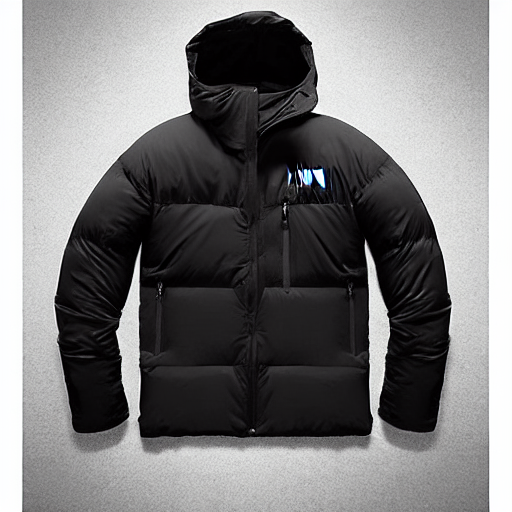

In [6]:
# this is the first dataset row's prompt of the clothing dataset
prompt = "outer, The North Face 1996 Eco Nuptse Jacket Black, a photography of the north face black down jacket"
image = pipe(prompt).images[0]
image # 512 x 512 pixel image produced by diffusion model

### Testing out Pytorch Stable Diffusion Model

In [17]:
model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"
ORIGINAL_MODEL_PATH = './model_downloads/original'

from models.StableDiffusion import StableDiffusion
import torch

stable_diffusion_model = StableDiffusion(model_id)

stable_diffusion_model = stable_diffusion_model.to(device)

  0%|          | 0/50 [00:00<?, ?it/s]

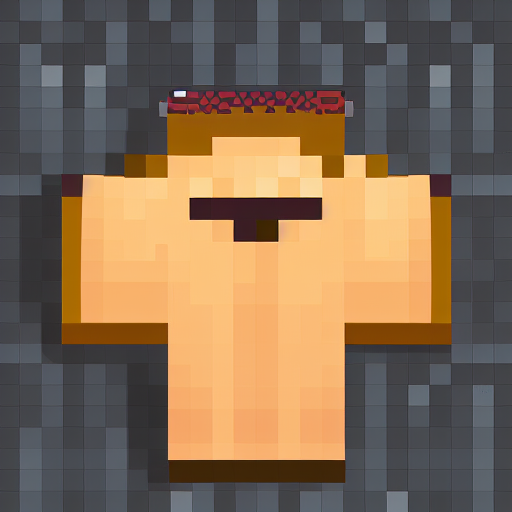

In [18]:
stable_diffusion_model.eval()
with torch.no_grad():
    image = stable_diffusion_model('a pixel art character with square black glasses, a hotdog-shaped head and a peachy-colored body on a warm background')
image[0]

## Testing out finetuned pytorch stable diffusion models

In [1]:
model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"
ORIGINAL_MODEL_PATH = './model_downloads/original' 

from models.StableDiffusion import StableDiffusion
import torch
lora_path = './model_downloads/clothes_finetuned_model/checkpoint-3000'
stable_diffusion_model = StableDiffusion(model_id, lora_path=lora_path)

stable_diffusion_model = stable_diffusion_model.to(device, dtype=torch.float32)

  0%|          | 0/50 [00:00<?, ?it/s]

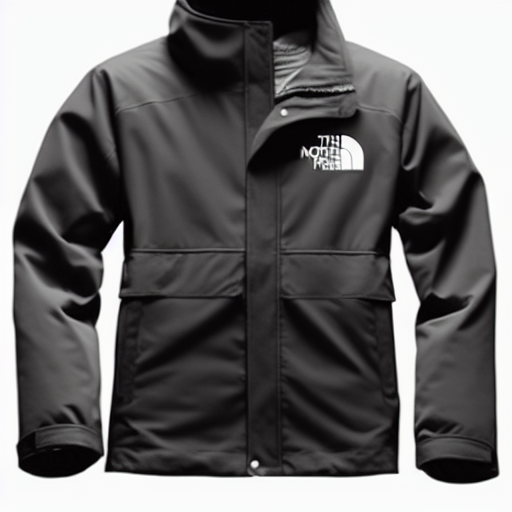

In [2]:
stable_diffusion_model.eval()
prompts = ['north face black jacket']
with torch.no_grad():
    image = stable_diffusion_model(prompts)
image[0]

In [15]:
lora_path = './model_downloads/pixelart_finetuned_model/checkpoint-4000'
stable_diffusion_model = StableDiffusion(model_id, lora_path=lora_path)

stable_diffusion_model = stable_diffusion_model.to(device, dtype=torch.float32)

  0%|          | 0/50 [00:00<?, ?it/s]

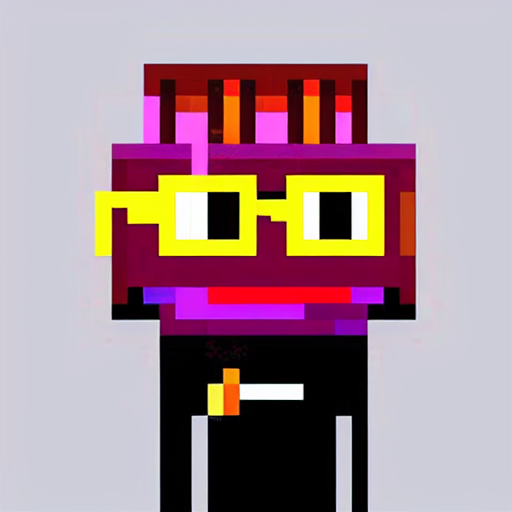

In [16]:
stable_diffusion_model.eval()
prompts = ['a pixel art character with square black glasses, a hotdog-shaped head and a peachy-colored body on a warm background']
with torch.no_grad():
    image = stable_diffusion_model(prompts)
image[0]

## Test out Blended Diffusion Model

In [1]:
model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"

from models.BlendedDiffusion import BlendedDiffusion
import torch
lora_paths = ['./model_downloads/clothes_finetuned_model', './model_downloads/pixelart_finetuned_model']
stable_diffusion_model = BlendedDiffusion(model_id, lora_paths)

stable_diffusion_model = stable_diffusion_model.to(device, dtype=torch.float32)

  0%|          | 0/50 [00:00<?, ?it/s]

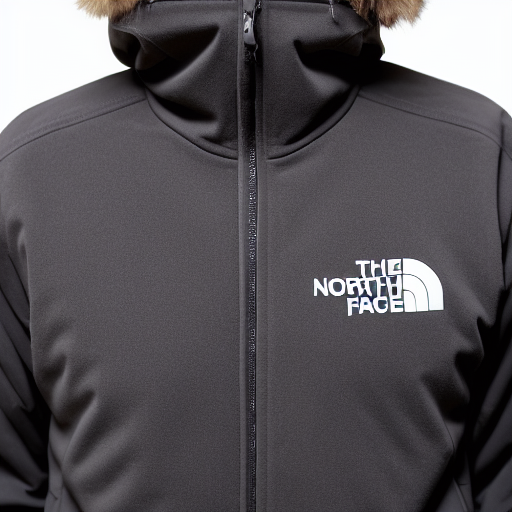

In [2]:
stable_diffusion_model.eval()
prompts = ['north face black jacket']
with torch.no_grad():
    image = stable_diffusion_model(prompts)
image[0]